In [1]:
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,MaxPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
import pandas as pd
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image



In [2]:
#pip install --upgrade tensorflow


In [3]:
data=pd.read_csv('/content/drive/MyDrive/deep learning/age_gender.csv')
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
data['gender'].value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [5]:
data.shape

(23705, 5)

In [6]:
data['age'].value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
111       1
103       1
Name: age, Length: 104, dtype: int64

In [7]:
data['ethnicity'].value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64

In [8]:
data['gender'].value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [9]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [10]:

data['pixels'][0]

array([129., 128., 128., ..., 146., 146., 146.], dtype=float32)

In [11]:
x=np.array(data['pixels'].tolist())

In [12]:

x.shape

(23705, 2304)

In [13]:
x[0]

array([129., 128., 128., ..., 146., 146., 146.], dtype=float32)

In [14]:
x=x.reshape(23705,48,48,1)

In [15]:
x[0].shape

(48, 48, 1)

Text(0.5, 0, 'Age:1  Ethnicity:2  Gender:0')

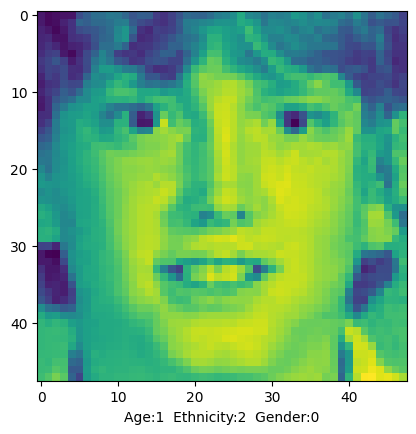

In [16]:
plt.imshow(x[1702])
plt.xlabel(
        "Age:"+str(data['age'].iloc[0])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[0])+
        "  Gender:"+ str(data['gender'].iloc[0])
    )

In [17]:
# plt.imsave('/content/drive/MyDrive/deep learning/image4.png',x[[[2000]]], cmap='gray')

**Age prediction**

In [18]:
data['age']=pd.cut(data['age'],bins=[0,3,18,45,64,116],labels=['0','1','2','3','4'])

In [19]:
y=to_categorical(np.array(data['age']),num_classes=5)

In [20]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [21]:
data.shape

(23705, 5)

In [22]:
model_age = Sequential()
model_age.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same',input_shape=(48,48,1),kernel_regularizer=l2(0.01)))
model_age.add(BatchNormalization())
model_age.add(MaxPool2D(pool_size=(2,2)))

model_age.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=l2(0.01)))
model_age.add(BatchNormalization())
model_age.add(MaxPool2D(pool_size=(2,2)))

model_age.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=l2(0.01)))
model_age.add(MaxPool2D(pool_size=(2,2)))
model_age.add(Flatten())

model_age.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01)))
model_age.add(Dropout(0.5))
model_age.add(Dense(5,activation='softmax'))

# sgd = tf.keras.optimizers.SGD(momentum=0.9)
model_age.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                        

In [24]:
early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', patience=3, verbose=1,
                                            factor=0.5, min_lr=0.00001)

In [25]:
epochs = 200
batch_size = 64

history_age = model_age.fit(x_train, y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch= x_train.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/200
293/296 [============================>.] - ETA: 0s - loss: 2.6399 - accuracy: 0.6671

296/296 [==============================] - 10s 9ms/step - loss: 2.6251 - accuracy: 0.6682 - val_loss: 1.2625 - val_accuracy: 0.7209 - lr: 0.0010
Epoch 2/200
294/296 [============================>.] - ETA: 0s - loss: 1.0479 - accuracy: 0.7343

296/296 [==============================] - 2s 7ms/step - loss: 1.0481 - accuracy: 0.7341 - val_loss: 0.8842 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 3/200
290/296 [============================>.] - ETA: 0s - loss: 0.8596 - accuracy: 0.7503

296/296 [==============================] - 2s 7ms/step - loss: 0.8605 - accuracy: 0.7501 - val_loss: 0.8253 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 4/200
291/296 [============================>.] - ETA: 0s - loss: 0.7992 - accuracy: 0.7657

296/296 [==============================] - 2s 6ms/step - loss: 0.7992 - accuracy: 0.7659 - val_loss: 0.8756 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 5/200
296/296 [==============================] - ETA: 0s - loss: 0.7665 - accuracy: 0.7753

296/296 [==============================] - 2s 7ms/step - loss: 0.7665 - accuracy: 0.7753 - val_loss: 0.8442 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 6/200
295/296 [============================>.] - ETA: 0s - loss: 0.7472 - accuracy: 0.7748

296/296 [==============================] - 2s 7ms/step - loss: 0.7476 - accuracy: 0.7747 - val_loss: 0.7753 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 7/200
295/296 [============================>.] - ETA: 0s - loss: 0.7387 - accuracy: 0.7842

296/296 [==============================] - 2s 8ms/step - loss: 0.7390 - accuracy: 0.7839 - val_loss: 0.7355 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 8/200
288/296 [============================>.] - ETA: 0s - loss: 0.7215 - accuracy: 0.7846

296/296 [==============================] - 2s 7ms/step - loss: 0.7221 - accuracy: 0.7841 - val_loss: 0.7768 - val_accuracy: 0.7711 - lr: 0.0010
Epoch 9/200
289/296 [============================>.] - ETA: 0s - loss: 0.7142 - accuracy: 0.7914

296/296 [==============================] - 2s 6ms/step - loss: 0.7146 - accuracy: 0.7916 - val_loss: 0.9040 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 10/200
292/296 [============================>.] - ETA: 0s - loss: 0.6998 - accuracy: 0.7930

296/296 [==============================] - 2s 7ms/step - loss: 0.6994 - accuracy: 0.7931 - val_loss: 0.8091 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 11/200
292/296 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.7971

296/296 [==============================] - 2s 7ms/step - loss: 0.6899 - accuracy: 0.7968 - val_loss: 0.7315 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 12/200
292/296 [============================>.] - ETA: 0s - loss: 0.6871 - accuracy: 0.7990

296/296 [==============================] - 2s 7ms/step - loss: 0.6876 - accuracy: 0.7986 - val_loss: 0.9934 - val_accuracy: 0.7142 - lr: 0.0010
Epoch 13/200
289/296 [============================>.] - ETA: 0s - loss: 0.6947 - accuracy: 0.7970

296/296 [==============================] - 2s 7ms/step - loss: 0.6968 - accuracy: 0.7961 - val_loss: 0.7682 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 14/200
291/296 [============================>.] - ETA: 0s - loss: 0.6743 - accuracy: 0.8040

296/296 [==============================] - 2s 8ms/step - loss: 0.6745 - accuracy: 0.8038 - val_loss: 0.8107 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 15/200
296/296 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.8001

296/296 [==============================] - 2s 7ms/step - loss: 0.6785 - accuracy: 0.8001 - val_loss: 0.7757 - val_accuracy: 0.7699 - lr: 0.0010
Epoch 16/200
290/296 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.8046

296/296 [==============================] - 2s 6ms/step - loss: 0.6771 - accuracy: 0.8043 - val_loss: 0.8714 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 17/200
293/296 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.8077

296/296 [==============================] - 2s 7ms/step - loss: 0.6734 - accuracy: 0.8076 - val_loss: 0.7384 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 18/200
293/296 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.8083

296/296 [==============================] - 2s 6ms/step - loss: 0.6722 - accuracy: 0.8078 - val_loss: 0.8647 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 19/200
292/296 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.8098

296/296 [==============================] - 2s 7ms/step - loss: 0.6630 - accuracy: 0.8094 - val_loss: 0.9570 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 20/200
290/296 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.8126

296/296 [==============================] - 2s 7ms/step - loss: 0.6601 - accuracy: 0.8126 - val_loss: 0.7308 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 21/200
293/296 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.8144

296/296 [==============================] - 2s 8ms/step - loss: 0.6657 - accuracy: 0.8146 - val_loss: 0.7710 - val_accuracy: 0.7724 - lr: 0.0010


In [26]:
loss, acc = model_age.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.7315456867218018
Test Accuracy: 0.7861210703849792


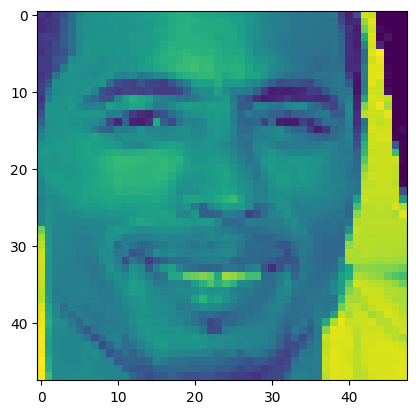

In [27]:
plt.imshow(x_test[1702])

In [28]:
input_image = np.expand_dims(x_test[1702], axis=0)

predictions = model_age.predict(input_image)
np.argmax(predictions)

1/1 [==============================] - 0s 492ms/step


2

In [29]:
# from tensorflow.keras.models import save_model

# # Assuming your model is named 'model'
# save_model(model_age, '/content/drive/MyDrive/deep learning/model_age_save.h5')


In [43]:
from tensorflow.keras.models import load_model
load_model=load_model('/content/drive/MyDrive/deep learning/model_age_save.h5')

In [44]:
input_image = np.expand_dims(x_test[2000], axis=0)

predictions1 = load_model.predict(resized_img)
Age=np.argmax(predictions1)
Age

1/1 [==============================] - 0s 87ms/step


2

age 2 means that it falls between the range (18-45)
0=(0-3),
1=(3-18),
2=(18-45),
3=(45-64),
4=(64-116)


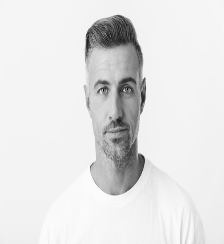

In [32]:
input_image =cv2.imread('/content/drive/MyDrive/vision_images/facejpg.jpg')

gray_image=cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)
img_array1=cv2.resize(gray_image,(224,244))
cv2_imshow(img_array1)

In [33]:
img_array1.shape

(244, 224)

In [35]:
# img_array2.shape

In [36]:
resized_img = cv2.resize(img_array1,(48, 48), interpolation=cv2.INTER_AREA)
resized_img = resized_img.reshape(1, 48, 48, 1)

In [38]:
resized_img.shape

(1, 48, 48, 1)

In [39]:
resized_img.dtype

dtype('uint8')

In [40]:
resized_img=resized_img.astype('float32')


In [41]:
#display(resized_img)

In [42]:
input_image = np.expand_dims(x_test[2900], axis=0)

predictions = load_model.predict(resized_img)
np.argmax(predictions)

1/1 [==============================] - 0s 86ms/step


2

Gender Prediction


In [45]:
y= data['gender']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state = 42)

In [46]:
print(x.shape)
print(len(y))


(23705, 48, 48, 1)
23705


In [47]:
model_gender = Sequential()
model_gender.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same',input_shape=(48,48,1),kernel_regularizer=l2(0.01)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2,2)))

model_gender.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=l2(0.01)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2,2)))

model_gender.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=l2(0.01)))
model_gender.add(MaxPool2D(pool_size=(2,2)))
model_gender.add(Flatten())

model_gender.add(Dense(256,activation='relu'))
model_gender.add(Dropout(0.5))
model_gender.add(Dense(1,activation='sigmoid'))

sgd = tf.keras.optimizers.SGD(momentum=0.9)
model_gender.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,
                                            factor=0.5, min_lr=0.00001)

In [49]:
epochs = 200
batch_size = 64

history_gender = model_gender.fit(x_train, y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch= x_train.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/200
294/296 [============================>.] - ETA: 0s - loss: 0.8593 - accuracy: 0.7944

296/296 [==============================] - 5s 8ms/step - loss: 0.8575 - accuracy: 0.7949 - val_loss: 0.5712 - val_accuracy: 0.8637 - lr: 0.0010
Epoch 2/200
292/296 [============================>.] - ETA: 0s - loss: 0.4660 - accuracy: 0.8696

296/296 [==============================] - 2s 7ms/step - loss: 0.4664 - accuracy: 0.8692 - val_loss: 0.4088 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 3/200
294/296 [============================>.] - ETA: 0s - loss: 0.3733 - accuracy: 0.8840

296/296 [==============================] - 2s 7ms/step - loss: 0.3735 - accuracy: 0.8838 - val_loss: 0.3943 - val_accuracy: 0.8711 - lr: 0.0010
Epoch 4/200
293/296 [============================>.] - ETA: 0s - loss: 0.3362 - accuracy: 0.8970

296/296 [==============================] - 2s 8ms/step - loss: 0.3364 - accuracy: 0.8967 - val_loss: 0.3457 - val_accuracy: 0.8874 - lr: 0.0010
Epoch 5/200
293/296 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8966

296/296 [==============================] - 3s 9ms/step - loss: 0.3249 - accuracy: 0.8962 - val_loss: 0.3416 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 6/200
293/296 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.9031

296/296 [==============================] - 2s 8ms/step - loss: 0.3146 - accuracy: 0.9030 - val_loss: 0.3337 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 7/200
293/296 [============================>.] - ETA: 0s - loss: 0.3081 - accuracy: 0.9049

296/296 [==============================] - 2s 7ms/step - loss: 0.3084 - accuracy: 0.9048 - val_loss: 0.3616 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 8/200
292/296 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.9091

296/296 [==============================] - 2s 7ms/step - loss: 0.2993 - accuracy: 0.9092 - val_loss: 0.3341 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 9/200
289/296 [============================>.] - ETA: 0s - loss: 0.2945 - accuracy: 0.9106

296/296 [==============================] - 2s 6ms/step - loss: 0.2939 - accuracy: 0.9107 - val_loss: 0.3518 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 10/200
296/296 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.9162

296/296 [==============================] - 2s 7ms/step - loss: 0.2861 - accuracy: 0.9162 - val_loss: 0.3421 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 11/200
291/296 [============================>.] - ETA: 0s - loss: 0.2812 - accuracy: 0.9181

296/296 [==============================] - 2s 8ms/step - loss: 0.2817 - accuracy: 0.9183 - val_loss: 0.3422 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 12/200
292/296 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.9175

296/296 [==============================] - 2s 8ms/step - loss: 0.2787 - accuracy: 0.9174 - val_loss: 0.3412 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 13/200
292/296 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.9208

296/296 [==============================] - 2s 7ms/step - loss: 0.2750 - accuracy: 0.9208 - val_loss: 0.3702 - val_accuracy: 0.8808 - lr: 0.0010
Epoch 14/200
295/296 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.9258

296/296 [==============================] - 2s 6ms/step - loss: 0.2686 - accuracy: 0.9258 - val_loss: 0.3451 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 15/200
296/296 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.9265

296/296 [==============================] - 2s 7ms/step - loss: 0.2678 - accuracy: 0.9265 - val_loss: 0.3711 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 16/200
292/296 [============================>.] - ETA: 0s - loss: 0.2647 - accuracy: 0.9295

296/296 [==============================] - 2s 7ms/step - loss: 0.2650 - accuracy: 0.9292 - val_loss: 0.3513 - val_accuracy: 0.8933 - lr: 0.0010


In [50]:
loss, acc = model_gender.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.3337306082248688
Test Accuracy: 0.8909512758255005


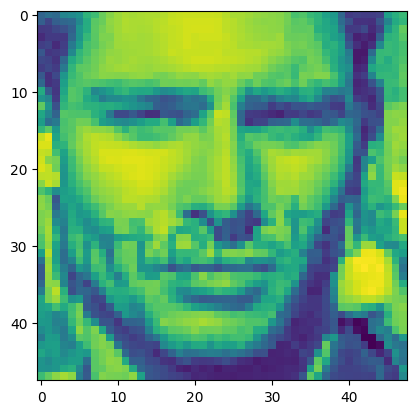

In [51]:
plt.imshow(x_test[2370])

In [52]:
input_image = np.expand_dims(x_test[2370], axis=0)

predictions = model_gender.predict(input_image)
np.argmax(predictions)

1/1 [==============================] - 0s 86ms/step


0

In [53]:
# from tensorflow.keras.models import save_model
# # Assuming your model is named 'model'
# save_model(model_gender, '/content/drive/MyDrive/deep learning/model_gender_save.h5')


In [54]:
from tensorflow.keras.models import load_model
load_model1=load_model('/content/drive/MyDrive/deep learning/model_gender_save.h5')



In [55]:
input_image = np.expand_dims(x_test[1], axis=0)

predictions2 = load_model1.predict(resized_img)
Gender=np.argmax(predictions2)
Gender

1/1 [==============================] - 0s 94ms/step


0

0 means male   and  1 means women

Ethinicity Prediction

In [56]:
ethnicity_matrix = np.array(data["ethnicity"])
y = to_categorical(ethnicity_matrix, num_classes = 5)

In [57]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state = 42)

In [58]:
model_ethnicity = Sequential()
model_ethnicity.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same',input_shape=(48,48,1),kernel_regularizer=l2(0.01)))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPool2D(pool_size=(2,2)))

model_ethnicity.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=l2(0.01)))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPool2D(pool_size=(2,2)))

model_ethnicity.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=l2(0.01)))
model_ethnicity.add(MaxPool2D(pool_size=(2,2)))
model_ethnicity.add(Flatten())

model_ethnicity.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01)))
model_ethnicity.add(Dropout(0.5))
model_ethnicity.add(Dense(5,activation='softmax'))

model_ethnicity.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,
                                            factor=0.5, min_lr=0.00001)

In [60]:
epochs = 200
batch_size = 64

history_ethnicity = model_ethnicity.fit(x_train, y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch= x_train.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/200
294/296 [============================>.] - ETA: 0s - loss: 3.1498 - accuracy: 0.5703

296/296 [==============================] - 5s 7ms/step - loss: 3.1393 - accuracy: 0.5709 - val_loss: 1.5607 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 2/200
295/296 [============================>.] - ETA: 0s - loss: 1.2733 - accuracy: 0.7043

296/296 [==============================] - 2s 6ms/step - loss: 1.2726 - accuracy: 0.7046 - val_loss: 1.1204 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 3/200
291/296 [============================>.] - ETA: 0s - loss: 1.0220 - accuracy: 0.7361

296/296 [==============================] - 2s 6ms/step - loss: 1.0210 - accuracy: 0.7360 - val_loss: 0.9496 - val_accuracy: 0.7547 - lr: 0.0010
Epoch 4/200
290/296 [============================>.] - ETA: 0s - loss: 0.9495 - accuracy: 0.7511

296/296 [==============================] - 2s 6ms/step - loss: 0.9505 - accuracy: 0.7508 - val_loss: 0.9252 - val_accuracy: 0.7452 - lr: 0.0010
Epoch 5/200
290/296 [============================>.] - ETA: 0s - loss: 0.9079 - accuracy: 0.7620

296/296 [==============================] - 2s 6ms/step - loss: 0.9081 - accuracy: 0.7619 - val_loss: 0.8804 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 6/200
292/296 [============================>.] - ETA: 0s - loss: 0.8907 - accuracy: 0.7682

296/296 [==============================] - 2s 8ms/step - loss: 0.8900 - accuracy: 0.7684 - val_loss: 0.9184 - val_accuracy: 0.7671 - lr: 0.0010
Epoch 7/200
292/296 [============================>.] - ETA: 0s - loss: 0.8858 - accuracy: 0.7711

296/296 [==============================] - 2s 8ms/step - loss: 0.8856 - accuracy: 0.7709 - val_loss: 0.9612 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 8/200
294/296 [============================>.] - ETA: 0s - loss: 0.8653 - accuracy: 0.7779

296/296 [==============================] - 2s 7ms/step - loss: 0.8646 - accuracy: 0.7782 - val_loss: 0.8951 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 9/200
290/296 [============================>.] - ETA: 0s - loss: 0.8512 - accuracy: 0.7824

296/296 [==============================] - 2s 6ms/step - loss: 0.8513 - accuracy: 0.7817 - val_loss: 0.8519 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 10/200
290/296 [============================>.] - ETA: 0s - loss: 0.8388 - accuracy: 0.7862

296/296 [==============================] - 2s 7ms/step - loss: 0.8399 - accuracy: 0.7860 - val_loss: 0.8991 - val_accuracy: 0.7650 - lr: 0.0010
Epoch 11/200
294/296 [============================>.] - ETA: 0s - loss: 0.8261 - accuracy: 0.7917

296/296 [==============================] - 2s 7ms/step - loss: 0.8262 - accuracy: 0.7916 - val_loss: 0.9782 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 12/200
293/296 [============================>.] - ETA: 0s - loss: 0.8194 - accuracy: 0.7952

296/296 [==============================] - 2s 7ms/step - loss: 0.8197 - accuracy: 0.7950 - val_loss: 0.8692 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 13/200
290/296 [============================>.] - ETA: 0s - loss: 0.8167 - accuracy: 0.7957

296/296 [==============================] - 2s 8ms/step - loss: 0.8169 - accuracy: 0.7958 - val_loss: 0.8669 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 14/200
294/296 [============================>.] - ETA: 0s - loss: 0.8135 - accuracy: 0.7977

296/296 [==============================] - 2s 8ms/step - loss: 0.8133 - accuracy: 0.7978 - val_loss: 0.8716 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 15/200
294/296 [============================>.] - ETA: 0s - loss: 0.8074 - accuracy: 0.8025

296/296 [==============================] - 2s 7ms/step - loss: 0.8085 - accuracy: 0.8019 - val_loss: 0.8603 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 16/200
294/296 [============================>.] - ETA: 0s - loss: 0.8027 - accuracy: 0.8036

296/296 [==============================] - 2s 7ms/step - loss: 0.8023 - accuracy: 0.8035 - val_loss: 0.8645 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 17/200
296/296 [==============================] - ETA: 0s - loss: 0.8001 - accuracy: 0.8040

296/296 [==============================] - 2s 7ms/step - loss: 0.8001 - accuracy: 0.8040 - val_loss: 0.8879 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 18/200
294/296 [============================>.] - ETA: 0s - loss: 0.7998 - accuracy: 0.8062

296/296 [==============================] - 2s 7ms/step - loss: 0.8008 - accuracy: 0.8060 - val_loss: 1.0025 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 19/200
294/296 [============================>.] - ETA: 0s - loss: 0.7905 - accuracy: 0.8058

296/296 [==============================] - 2s 7ms/step - loss: 0.7903 - accuracy: 0.8057 - val_loss: 0.9325 - val_accuracy: 0.7564 - lr: 0.0010


In [61]:
loss, acc = model_ethnicity.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.8519361615180969
Test Accuracy: 0.7835899591445923


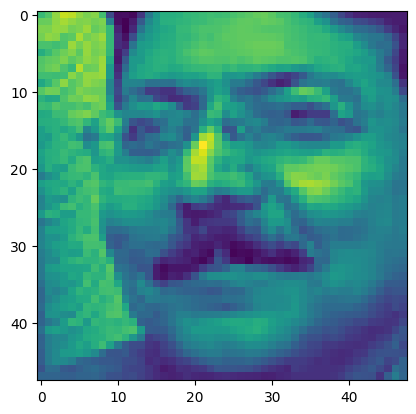

In [62]:
plt.imshow(x_test[2052])

In [63]:
input_image = np.expand_dims(x_test[2052], axis=0)

predictions = model_ethnicity.predict(input_image)
ethnicity=np.argmax(predictions)
ethnicity

1/1 [==============================] - 0s 92ms/step


3

Ethnicity

0: African
1: Caucasian
2: Asian
3: Hispanic/Latino
4: Other

In [64]:
# from tensorflow.keras.models import save_model
# # Assuming your model is named 'model'
# save_model(model_ethnicity, '/content/drive/MyDrive/deep learning/model_ethnicity_save.h5')


In [65]:
from tensorflow.keras.models import load_model
load_model2=load_model('/content/drive/MyDrive/deep learning/model_ethnicity_save.h5')



In [66]:
input_image = np.expand_dims(x_test[1], axis=0)

predictions3 = load_model2.predict(resized_img)
np.argmax(predictions3)


1/1 [==============================] - 0s 87ms/step


0

In [67]:
print("Age pred:", Age)
print("Gender pred:", Gender)
print("Ethnicity pred:", ethnicity)


Age pred: 2
Gender pred: 0
Ethnicity pred: 3
